In [9]:
import pandas as pd
import numpy as np
import time
import os
import sys
import utils 
import itertools
import random as rand
import math
import copy
sys.path.append('../')
sys.path.insert(1, '../exp')

# sklearn
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import compute_class_weight

import xgboost as xgb

#PostgreSQL
import psycopg2
from sqlalchemy import create_engine

# optuna
import optuna
from optuna import study, trial
from optuna.samplers import tpe, random
from optuna.importance._fanova import FanovaImportanceEvaluator
from optuna.importance._mean_decrease_impurity import MeanDecreaseImpurityImportanceEvaluator

# graph
import matplotlib.pyplot as plt
import plotly
from optuna.visualization import plot_optimization_history

# featuretools
import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

## Step 1. Load data & Join Table

Since we only need two tables: 'User' table and 'Log' table, we will concate three tables(ie. orders, order_products and products) together.


In [2]:
path = "../exp_data/Instacart/"
order_products = pd.read_csv(os.path.join(path, "order_products__prior.csv"))
orders = pd.read_csv(os.path.join(path, "orders.csv"))
departments = pd.read_csv(os.path.join(path, "departments.csv"))
products = pd.read_csv(os.path.join(path, "products.csv"))

user = pd.DataFrame()
user['user_id'] = orders["user_id"]
user = user.drop_duplicates(keep = 'first', inplace=False)

log = orders.merge(order_products).merge(products).sort_values(by=['user_id', 'order_number'])
print("number of users:", len(user), ", number of logs:", len(log))

orders_train = orders[orders['eval_set']=='train']
global user_train
user_train = pd.DataFrame()
user_train['user_id'] = orders_train['user_id']
log_train = user_train.merge(orders).merge(order_products).merge(products).sort_values(by=['user_id', 'order_number'])
print("training users:", len(user_train), "training data:", len(log_train))

orders_test = orders[orders['eval_set']=='test']
user_test = pd.DataFrame()
user_test['user_id'] = orders_test['user_id']
log_test = user_test.merge(orders).merge(order_products).merge(products).sort_values(by=['user_id', 'order_number'])
print("test users:", len(user_test), "test data:", len(log_test))

log.head()

number of users: 1000 , number of logs: 157932
training users: 646 training data: 104262
test users: 354 test data: 53670


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,3412510,427,prior,1,1,18,NaN,17948,1,0,Frozen Organic Wild Blueberries,116,1
136,3412510,427,prior,1,1,18,NaN,24852,2,0,Banana,24,4
2480,3412510,427,prior,1,1,18,NaN,28204,3,0,Organic Fuji Apple,24,4
2902,3412510,427,prior,1,1,18,NaN,23102,4,0,Organic 1% Milk,84,16
2915,3412510,427,prior,1,1,18,NaN,432,5,0,Vanilla Almond Breeze Almond Milk,91,16


### Convert product_name into 0/1 
Because 'product_name' attribute has too many distinct values, here we simplify the attribute with only two values. 

If the product name contains 'Banana', then product_name=True, otherwise, Flase. 

In [3]:
new_product_name = log_train['product_name'].str.contains(r'Banana')
log_train = log_train.drop('product_name', 1)
log_train['product_name'] = new_product_name
log_train = log_train[['user_id', 'order_id', 'product_id', 'eval_set', 'order_number', 
                      'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order', 
                       'reordered', 'aisle_id', 'department_id', 'product_name']]
log_train['product_name'] = log_train['product_name'].astype(int)
log_train = log_train.fillna(0)
print("# Banana:", len(log_train[log_train['product_name']==True]), "# non-Banana:", len(log_train[log_train['product_name']==False]))
log_train.head()


# Banana: 3520 # non-Banana: 100742


,user_id,order_id,product_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,aisle_id,department_id,product_name
0,892,2557057,21288,prior,1,5,19,0.0,1,0,24,4,0
74,892,2557057,47766,prior,1,5,19,0.0,2,0,24,4,0
676,892,2557057,21903,prior,1,5,19,0.0,3,0,123,4,0
1457,892,2557057,38313,prior,1,5,19,0.0,4,0,50,19,1
1497,892,2557057,23181,prior,1,5,19,0.0,5,0,35,12,0


## Step 2. Make Labels

In [4]:
training = log_train[log_train['eval_set']=='train']
has_Banana = {}
for i, row in training.iterrows():
    if row[-1] == True:
        has_Banana.update({row[0]: 1})
print('# of users buy banana', len(has_Banana))

# of users buy banana 209


In [5]:
user_train['label'] = np.nan
for item in has_Banana.items():
    user_train.loc[user_train['user_id'] == item[0], 'label'] = 1

# fillna with 0 
user_train = user_train.fillna(0)
print("neg samples:", len(user_train[user_train['label']==0]))
print("pos samples:", len(user_train[user_train['label']==1]))
user_train.head()

neg samples: 437
pos samples: 209


,user_id,label
27,892,0.0
31,1048,0.0
48,1662,0.0
56,1849,0.0
128,2094,1.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
        user_train.drop(['label'], axis=1), user_train['label'], test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
train_data = X_train
train_data['label'] = y_train
test_data = X_test
test_data['label'] = y_test

(516, 1) (130, 1)


In [7]:
global copy_train_data, copy_test_data, train_data, test_data
global trail_auc_store, trail_mi_store, train_auc_store

trail_auc_store = []
trail_mi_store = []
trail_args_store = []
train_auc_store = []

global random_args_log, tpe_args_log
global random_user_train_log, tpe_user_train_log

random_args_log = {}
tpe_args_log = {}
random_user_train_log = {}
tpe_user_train_log = {}

global eva_global, seed_global

## Step 3. Store table in PostragSQL
Store log_train to databse

In [8]:
engine = utils.store_instacart(log_train)

{'user': 'lydiazheng', 'channel_binding': 'prefer', 'dbname': 'auto_fg', 'host': '127.0.0.1', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 13.3 on x86_64-apple-darwin19.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 

log_train Table created successfully in PostgreSQL. 


PostgreSQL connection is closed


## Step 4. Feature Generation & Machine Learning


In [10]:
log_train["index"] = log_train["user_id"].astype(str) + "_" + log_train["order_id"].astype(str) + "_" + log_train["product_id"].astype(str)
log_train = log_train[["index", "user_id", "order_id", "product_id", "product_name", "department_id", "order_dow", 
                     "days_since_prior_order"]]

log_train_copy = copy.deepcopy(log_train)
log_train_copy = log_train_copy.rename({'index': 'index_copy'}, axis=1)
log_train_copy['unique_id'] = range(0, len(log_train_copy))
log_train_copy.head()

,index_copy,user_id,order_id,product_id,product_name,department_id,order_dow,days_since_prior_order,unique_id
0,892_2557057_21288,892,2557057,21288,0,4,5,0.0,0
74,892_2557057_47766,892,2557057,47766,0,4,5,0.0,1
676,892_2557057_21903,892,2557057,21903,0,4,5,0.0,2
1457,892_2557057_38313,892,2557057,38313,1,19,5,0.0,3
1497,892_2557057_23181,892,2557057,23181,0,12,5,0.0,4


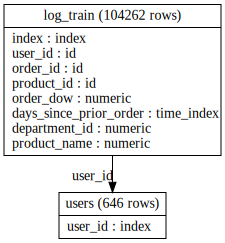

In [11]:
log_train_vtypes = {
    "index": ft.variable_types.Index,
    "user_id": ft.variable_types.Id,
    "order_id": ft.variable_types.Id,
    "product_id": ft.variable_types.Id,
    "order_dow": ft.variable_types.Numeric,
    "days_since_prior_order": ft.variable_types.TimeIndex,
    "department_id": ft.variable_types.Numeric,
    "product_name": ft.variable_types.Numeric
}

es = ft.EntitySet("instacart")
es.entity_from_dataframe(entity_id="log_train",
                         dataframe=log_train,
                         index="index",
                         variable_types=log_train_vtypes)

es.normalize_entity(base_entity_id="log_train", new_entity_id="users", index="user_id")

es.plot()

In [12]:
start = time.time()
feature_matrix, features = ft.dfs(target_entity="users",
                                  agg_primitives = ["sum", "min", "max", "count", "mean"],
#                                   where_primitives = ["count"],
                                  trans_primitives = [],
                                  ignore_variables={"log_train":["order_id", "product_id", "department_id"]},
                                  entityset=es,
                                  verbose=True)
end = time.time()
print("Time:", end-start)

Built 9 features
Elapsed: 00:00 | Progress: 100%|██████████
Time: 0.12410116195678711


In [13]:
feature_matrix.head()

,SUM(log_train.product_name),SUM(log_train.order_dow),MIN(log_train.product_name),MIN(log_train.order_dow),MAX(log_train.product_name),MAX(log_train.order_dow),COUNT(log_train),MEAN(log_train.product_name),MEAN(log_train.order_dow)
user_id,,,,,,,,,
892,1,453,0,0,1,6,128,0.007812,3.539062
1048,0,62,0,1,0,4,35,0.000000,1.771429
1662,0,44,0,0,0,5,17,0.000000,2.588235
1849,0,27,0,0,0,6,14,0.000000,1.928571
2094,30,1504,0,0,1,6,525,0.057143,2.864762


# Get Train & Test data

In [14]:
train_data = train_data.merge(feature_matrix, on='user_id', how="left")
test_data = test_data.merge(feature_matrix, on='user_id', how="left")

copy_train_data = copy.deepcopy(train_data)
copy_test_data = copy.deepcopy(test_data)

train_data = train_data.reindex(sorted(train_data.columns), axis=1)
test_data = test_data.reindex(sorted(test_data.columns), axis=1)

In [15]:
train_data.head()

,COUNT(log_train),MAX(log_train.order_dow),MAX(log_train.product_name),MEAN(log_train.order_dow),MEAN(log_train.product_name),MIN(log_train.order_dow),MIN(log_train.product_name),SUM(log_train.order_dow),SUM(log_train.product_name),label,user_id
0,104,6,0,2.519231,0.000000,1,0,262,0,0.0,12041
1,477,6,1,3.027254,0.027254,0,0,1444,13,0.0,91188
2,46,5,1,3.282609,0.021739,1,0,151,1,0.0,188359
3,87,6,1,3.816092,0.034483,0,0,332,3,1.0,206038
4,111,5,1,2.684685,0.027027,0,0,298,3,0.0,95764


In [16]:
test_data.head()

,COUNT(log_train),MAX(log_train.order_dow),MAX(log_train.product_name),MEAN(log_train.order_dow),MEAN(log_train.product_name),MIN(log_train.order_dow),MIN(log_train.product_name),SUM(log_train.order_dow),SUM(log_train.product_name),label,user_id
0,19,5,1,3.210526,0.052632,1,0,61,1,0.0,203828
1,126,6,1,1.896825,0.079365,0,0,239,10,1.0,120259
2,90,6,1,3.655556,0.011111,0,0,329,1,0.0,111223
3,334,6,0,3.401198,0.000000,0,0,1136,0,0.0,96026
4,203,6,1,2.940887,0.019704,0,0,597,4,1.0,28734


# SQLGEN

In [17]:
# set # of evaluation of opt algo
global res_x 
res_x = list()

aggregation = ['SUM', 'MIN', 'MAX', 'COUNT', 'AVG'] 
categorical_m = ['product_name', 'order_dow']
categorical = ['product_name', 'department_id', 'order_dow']
numerical = ['days_since_prior_order']
attributes = categorical + numerical

In [18]:
def update_user_train(args, train_data):  
    agg, m, lb_day, ub_day, w_cat_value_0, w_cat_value_1, w_cat_value_2 = args 
    agg = aggregation[agg]
    m = categorical_m[m]
    
    w_cat_value_temp = [w_cat_value_0, w_cat_value_1, w_cat_value_2]
    w_cat = []
    w_cat_value = []

    for i in range(len(categorical)):
        if w_cat_value_temp[i] != -1:
            w_cat.append(categorical[i])
            w_cat_value.append(w_cat_value_temp[i])
            
    sql_output = utils.generate_feature_in_small_space(engine, agg, m, lb_day, ub_day, w_cat, w_cat_value) 
    w_cat_str = "_".join(str(w_cat[x])+'='+str(w_cat_value[x]) for x in range(len(w_cat)))
    new_feature = pd.DataFrame(sql_output, columns = ['user_id', agg+'('+m+')_'+w_cat_str+'_'+'lb_day='+str(lb_day)+"_ub_day="+str(ub_day)]) #+'='+g_cat
    new_feature = new_feature.astype('float')
    new_train_data = train_data.merge(new_feature, how='left')
    
    return new_train_data, args

In [19]:
# define an objective function

def objective(trial):
    agg = trial.suggest_categorical('agg', np.array([i for i in range(len(aggregation))]))
    m = trial.suggest_categorical('m', np.array([i for i in range(len(categorical_m))]))  
    lb_day = trial.suggest_int('lb_day', 0,14)
    ub_day = trial.suggest_int('ub_day', 15,30)
    w_cat_value_0 = trial.suggest_categorical('w_cat_value_0', np.append(log_train[categorical[0]].unique(), [-1], 0))
    w_cat_value_1 = trial.suggest_categorical('w_cat_value_1', np.append(log_train[categorical[1]].unique(), [-1], 0))
    w_cat_value_2 = trial.suggest_categorical('w_cat_value_2', np.append(log_train[categorical[2]].unique(), [-1], 0))
    
    args = [agg, m, lb_day, ub_day, w_cat_value_0, w_cat_value_1, w_cat_value_2]
    new_train_data, args = update_user_train(args, train_data)
    score, _ = utils.model(new_train_data)
    
    for x in res_x:
        if args == x:
            score -= 0.2
            break
            
    print(args, " Accuracy: ", score)
    return score

In [20]:
# define a NEW function with mutual information

def mi(trial):
    agg = trial.suggest_categorical('agg', np.array([i for i in range(len(aggregation))]))
    m = trial.suggest_categorical('m', np.array([i for i in range(len(categorical_m))]))  
    lb_day = trial.suggest_int('lb_day', 0,14)
    ub_day = trial.suggest_int('ub_day', 15,30)
    w_cat_value_0 = trial.suggest_categorical('w_cat_value_0', np.append(log_train[categorical[0]].unique(), [-1], 0))
    w_cat_value_1 = trial.suggest_categorical('w_cat_value_1', np.append(log_train[categorical[1]].unique(), [-1], 0))
    w_cat_value_2 = trial.suggest_categorical('w_cat_value_2', np.append(log_train[categorical[2]].unique(), [-1], 0))
    
    args = [agg, m, lb_day, ub_day, w_cat_value_0, w_cat_value_1, w_cat_value_2]
    new_train_data, args = update_user_train(args, train_data)

    mi_matrix = mutual_info_classif(new_train_data.fillna(0), new_train_data['label'], random_state=0)
    mi_score = mi_matrix[-1]
    
    for x in res_x:
        if args == x:
            mi_score = 0
            break
            
    trail_mi_store.append(mi_score)
    trail_args_store.append(args)
    print(args, "MI:", mi_score)
    return mi_score

In [21]:
# Random sampling 
def evaluate(trial_arr, mi_log, train_size):

    x_features = pd.DataFrame()
    x_features['index'] = range(0, len(mi_log))
    x_features['mi'] = mi_log
    x_features['agg'] = [trial_arr[i]['agg'] for i in range(len(trial_arr))]
    x_features['m'] = [trial_arr[i]['m'] for i in range(len(trial_arr))]
    x_features['lb_day'] = [trial_arr[i]['lb_day'] for i in range(len(trial_arr))]
    x_features['ub_day'] = [trial_arr[i]['ub_day'] for i in range(len(trial_arr))]
    x_features['w_cat_value_0'] = [trial_arr[i]['w_cat_value_0'] for i in range(len(trial_arr))]
    x_features['w_cat_value_1'] = [trial_arr[i]['w_cat_value_1'] for i in range(len(trial_arr))]
    x_features['w_cat_value_2'] = [trial_arr[i]['w_cat_value_2'] for i in range(len(trial_arr))]
    
    print(x_features.shape)
    x_train, x_test = train_test_split(x_features, train_size=train_size, random_state=0)

    y_acc = []
    for index, feature in x_train.iterrows():
        args = [int(feature['agg']),
               int(feature['m']),
               int(feature['lb_day']),
               int(feature['ub_day']),
               int(feature['w_cat_value_0']),
               int(feature['w_cat_value_1']),
               int(feature['w_cat_value_2'])] 
        new_train_data, args = update_user_train(args, train_data)
        
        y_acc.append(utils.model(new_train_data)[0])

    y_train = pd.DataFrame()
    y_train['index'] = x_train['index']
    y_train['label'] = y_acc
    
#     global train_auc_store
#     train_auc_store.append(x_train)
#     train_auc_store.append(y_train)
    
    global clf
    clf = RandomForestRegressor(random_state=0)
    clf.fit(x_train[['mi']], y_train['label'])
    
    global estimated_accuracy
    estimated_accuracy = clf.predict(x_features[['mi']])
    predict_y = pd.DataFrame()
    predict_y['index'] = range(0, len(mi_log))
    predict_y['label'] = estimated_accuracy
    
    for index, row in y_train.iterrows():
        predict_y.loc[predict_y['index'] == row['index'], 'label'] = row['label']
    
    best_trail_index = y_train.nlargest(1, ['label']).index[0]
    train_auc_store.append(predict_y['label'].to_numpy())
    return predict_y['label'].to_numpy(), best_trail_index

In [22]:
top = 5

n_calls = [1500] 
random_state_arr = [0] 
train_size_arr = [100]
all_store = []
for n_call in n_calls:
    tpe_args_log[n_call] = {}
    tpe_user_train_log[n_call] = {}
    for seed in random_state_arr:
        tpe_args_log[n_call][seed] = []

# SQLGEN - Opt3

In [ ]:
eva_store_optuna = []
train_auc_store
start = time.time()

for eva in n_calls:
    print("trails:", eva)
    eva_global = eva
    seed_store = []
    for seed in random_state_arr:
        seed_global = seed
        global train_data, res_x 
        res_optuna_lst = []
        res_optuna_fun = []
        res_x = list()
        train_data = copy_train_data
        print("seed:", seed)

        for i in range(top):
            tpe_result = study.create_study(
                direction="maximize", 
                sampler=tpe.TPESampler(n_startup_trials=20, seed=seed)) #
            tpe_result.optimize(objective, n_trials=eva, 
                                mi_initializer=mi, evaluate=evaluate, mi_init_trails=1000, train_size=train_size)

            best_trial = []
            for key, value in tpe_result.best_trial.params.items():
                best_trial.append(value)
            res_x.append(best_trial)

            train_data, args = update_user_train(best_trial, train_data)
            res_optuna_lst.append(tpe_result.best_trial.params)
            res_optuna_fun.append(tpe_result.best_value)

            print(tpe_result.best_trial.params, tpe_result.best_value)
            print(train_data.shape)
            tpe_args_log[eva][seed].append(args)
        seed_store.append(res_optuna_fun)
        tpe_user_train_log[eva][seed] = train_data

    eva_store_optuna.append(seed_store)
end = time.time()
print("Time:", end-start)

# Evaluate Test Accuracy

In [ ]:
def model_instacart(user_train):
    y = user_train['label']
    y = y.to_frame()
    X = user_train.drop(['label'], axis=1)
    X = X.fillna(0)

    clf = RandomForestClassifier(random_state=0)
    auc = cross_validate(clf, X, y, cv=5,scoring=('accuracy'), return_train_score=True, n_jobs=-1, return_estimator=True)
    valid_auc = auc['test_score'].mean()
    train_auc = auc['train_score'].mean()

    return train_auc, valid_auc, auc['estimator'][0]


In [ ]:
test_auc = {}
train_auc = {}
valid_auc = {}
for n_calls in tpe_args_log:
    for seed in tpe_args_log[n_calls]:
        test_auc[seed] = []
        train_auc[seed] = []
        valid_auc[seed] = []
        train_data = copy_train_data
        test_data = copy_test_data
        
        # Default AUC without new features
        train, valid, clf = model_instacart(train_data)
        train_auc[seed].append(train)
        valid_auc[seed].append(valid)
        test_pred = clf.predict(test_data.drop(columns='label', axis=1))
        test_auc[seed].append(metrics.accuracy_score(test_data['label'], test_pred))
        for args in tpe_args_log[n_calls][seed]:
            test_data, config = update_user_train(args, test_data)
            train_data, config = update_user_train(args, train_data)
            train, valid, clf = model_instacart(train_data)
            train_auc[seed].append(train)
            valid_auc[seed].append(valid)
            
            test_data = test_data.fillna(0)
            test_pred = clf.predict(test_data.drop(columns='label', axis=1))
            test_auc[seed].append(metrics.accuracy_score(test_data['label'], test_pred))
train_auc, valid_auc, test_auc